The system used as an example is PdML/Pt(111).
Here we are looking at the projected density of states of the dband of Pd.
Vaspkit was used to obtained the postprocessed data as PDOS_USER.dat
This script can be used on other other similar file formats.

OUTLINE
1. First visualize the total pdos.
2. Choose the range of integration.
3. Calcualte the momemnts (center of the band and the width as the sqrt of the second moment).

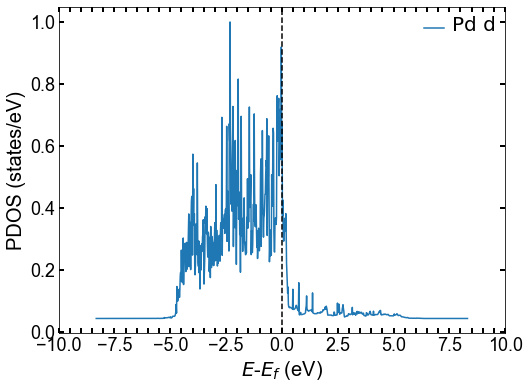

In [91]:
import numpy as np
import matplotlib as mpl
#mpl.use('Agg') #silent mode
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import sys

#This is a modified script form the vaspkit mypdosplot.py. 
#This version contains the normalization
#------------------ Functions ----------------------

#use to normalized the y axis using  y' = a + (y-ymin)(b-a)/y.max-y.min  where a , b is the range you want the scale to be.
def normalize(datarange):
    """this takes the passed data and normalize it in the range [a,b]
    """
    #y_norm = (datarange - np.min(datarange)) / np.ptp(datarange) #(np.max(datarange)- np.min(datarange))
    y_norm =  (datarange-np.min(datarange)) / (np.max(datarange)-np.min(datarange)) #np.ptp(datarange)
    return np.nan_to_num(y_norm) # this convert NAN values to zero. If there are any.


#------------------ FONT_setup ----------------------
font = {'family' : 'arial',
    'color'  : 'black',
    'weight' : 'normal',
    'size' : 20.0,
    }

#------------------- Data Read ----------------------
pdosfile= "PDOS_USER.dat"

with open(pdosfile,"r") as reader:
    legend = reader.readline()
legends=legend.split()[1:] #omits the 0th label
legends=[i.replace("_"," ") for i in legends]
legend_s=tuple(legends)
datas = np.loadtxt(pdosfile,dtype=np.float64,skiprows=1)

datanorm = normalize(datas) # normalize the Y axis the orbitals

#--------------------- PLOTs ------------------------
axe = plt.subplot(111)
# Color methods! choose only one of the two methods


axe.plot(datas[:,0], datanorm[:,1:],linewidth=1.5) #auto colors
#axe.fill_between(datas[:,0], datanorm[:,8].min(), datanorm[:,8], facecolor='orange', alpha=0.5,linestyle='-' )
#axe.plot(datas[:,0],datas[:,1:],linewidth=1.0) #auto colors



axe.set_xlabel(r'${E}$-$E_{f}$ (eV)',fontdict=font)
axe.set_ylabel(r'PDOS (states/eV)',fontdict=font)
plt.yticks(fontsize=font['size']-2,fontname=font['family'])
plt.xticks(fontsize=font['size']-2,fontname=font['family'])
plt.legend(legend_s,loc='best', frameon=False)
plt.xlim(( -10,  10)) # set y limits manually
axe.axvline(x=0, color='k',linestyle='--',linewidth=1.5)
span= 0.5
axe.xaxis.set_ticks(np.arange(-10,10, span), minor=True)
axe.tick_params(axis='both',  right=True, top= True, which='both', direction='in', width=2, size=5)

#axe.axhline(y=0, color='k',linestyle='--',linewidth=1.5)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=font['size'])
fig = plt.gcf()
fig.set_size_inches( 8, 6)
name = pdosfile
plt.show()
#plt.savefig(name+'.png', dpi= 300, format='png', transparent=True, style='presentation')

2. Choose the range of integration.

In [92]:
import pandas as pd
import numpy as np
import sys

"""
Here the data is obtained from the  PDOS_USER.dat file. 
I rewrote the code so that it uses pandas to do the filtering, instead of np.genfromtxt. 

The data for the projected density of states is usually in a format where the first column shows the energies and the other columns contains the projected density of states (pdos).
column1name = Energy, column2name = sum of density of states, columnNthname =  bands(orbitals) s p d.
Always check the documentation of the program used to get the density of states.

The Energy column from PDOS_USER.dat it is aalready referenced to the fermi energy as (E-Ef). I used vaspkit and chose the option to have the Energy referenced to the Ef. However, not all the pdos data files will have the Energy referenced to the  fermi level. 

This script can be modified to accept fermi_energy as an argument.
"""

first_limit_energy_i = -4.8
second_limit_energy_j = 1.0

#load the data and convert it to a dataframe object. 
dataPDOS = pd.read_csv("PDOS_USER.dat", sep=" ", skipinitialspace=True) #skipinitialspace->Skip spaces after delimiter.

print dataPDOS.head()

def energy_minus_fermi_energy (df, fermi_energy=None):
    
    """
    Retrun the energy referenced to the fermi level.
    Transforms the pandas column energy to energy minus the fermi level. E- Ef/  
    """
    if fermi_energy == None:
        return df
    if fermi_energy != None:
        return df - float(fermi_energy)


#Next a new column is created using the apply method and the function to reference the  energy to the fermi energy. apply takes as argumnet itself, and then the other arguments. I prefred to pass the second argument of the main function as a keyword. If it is passed as argument, you have to pass it as a tuple like args=(fermi_energy,) ( see documentation). 

dataPDOS["E-Ef"]= dataPDOS.iloc[:,0].apply(energy_minus_fermi_energy, fermi_energy= 0)

#Here we filtered the data in the range of the energies we want to integrate for the d band and width calcualtion.

pdos_filtered_data =  dataPDOS.loc[(dataPDOS["E-Ef"] >= first_limit_energy_i) & (dataPDOS["E-Ef"] <= second_limit_energy_j)]

pdos = pdos_filtered_data["Pd_d"]
energy = pdos_filtered_data["E-Ef"]
#dataPDOS.iloc[:,0].apply(energy_minus_fermi_energy, args=(0.35,)) #passed as argument
#dataPDOS.iloc[:,0].apply(energy_minus_fermi_energy, fermi_energy= 0.35) #  passed as a keyword

print "New data frame\n",dataPDOS.head()

#print(pdos_filtered_data.head())

   #Energy  Pd_d
0 -8.31815   0.0
1 -8.30115   0.0
2 -8.28415   0.0
3 -8.26815   0.0
4 -8.25115   0.0
New data frame
   #Energy  Pd_d     E-Ef
0 -8.31815   0.0 -8.31815
1 -8.30115   0.0 -8.30115
2 -8.28415   0.0 -8.28415
3 -8.26815   0.0 -8.26815
4 -8.25115   0.0 -8.25115


3. Calcualte the first and second momemnts ( center of the band and the width of the band resp.)

In [93]:
#J. Chem. Phys.137, 084703 (2012)  
# dband center  first moment of the projectedd-band density of states about the Fermi level (Ef)

# d-band width (Wd) computed as the square-root of the second moment of projected d-band density of states about thed-band center (Ed).
# You can obtain the p band  center and also calcualte the pband-width, in the same way.

I = np.trapz(pdos, energy)
center = np.trapz(pdos * energy, energy) / I
W_centered_width =  np.sqrt(np.trapz(pdos * (energy - center)**2, energy) / I)

print 'd-band center = %s eV\nd-band center width = %s eV\nintegral=%s' % (center, W_centered_width, I)


d-band center = -1.87375847851 eV
d-band center width = 1.37351172548 eV
integral=303.37017444
